# Homework 4 - ViT and Swin


Objective:
To implement and compare the performance of Vision Transformer and SWIN
models on the CIFAR-10 dataset for object classification, and to analyze their
decision-making processes using Grad-CAM visualization.

1) Data Preparation

We install the libraries

In [ ]:
!pip install torch torchvision timm pytorch-gradcam --quiet
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Load and prepare data

In [ ]:
# Normalisation CIFAR-10 (we call it later)
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2470, 0.2435, 0.2616])

# Definition of transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize, #(here we call normalization)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize, #(same)
])
# Dowloading and création of datasets :
train_ds = datasets.CIFAR10(root='.', train=True,  download=True, transform=train_transform)
test_ds  = datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


2) Model Selection and Fine-tuning



We create a function that prepares the model by calling ViT and SWIN Transformer. The function also modifies the classification header of each model to generate 1 class. We also choose Option 2 to freeze the earlier layers and refine only the classification header and subsequent layers to reduce computational demand.

In [ ]:
def prepare_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=10) #output 10 classes
    # Freeze all layers except the head
    for param in model.parameters():
        param.requires_grad = False
    # Unlock the classification head
    for param in model.get_classifier().parameters():
        param.requires_grad = True
    return model.to(device)

# selection of models
models = {
    'ViT': prepare_model('vit_base_patch16_224'),
    'Swin': prepare_model('swin_tiny_patch4_window7_224')
}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

3) Training

We create a training function and one for evaluate. We just have to call it in the loop.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    pbar = tqdm(loader, leave=False)
    total_loss = 0
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(xb)
            loss = criterion(preds, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * xb.size(0)
        pbar.set_postfix(train_loss=total_loss/((pbar.n+1)*loader.batch_size))
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        correct += (preds.argmax(1) == yb).sum().item()
        total += yb.size(0)
    return correct / total


Run : Training loop

In [ ]:
import torch.optim as optim

results = {}
criterion = nn.CrossEntropyLoss()

for name, model in models.items():
    print(f"\n {name} training ")
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=3e-4, weight_decay=1e-2) #We use AdamW as optimiser
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5) # we use cosine annealing as learning rate schedules
    scaler = torch.cuda.amp.GradScaler()

    best_acc = 0
# Part for printing progress bars
    for epoch in tqdm(range(1, 6), desc=f"{name} Epochs", leave=True):
        model.train()
        epoch_loss = 0

        batch_pbar = tqdm(train_loader, desc=f" Epoch {epoch}", leave=False)
        for xb, yb in batch_pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(xb)
                loss = criterion(preds, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item() * xb.size(0)
            batch_pbar.set_postfix(loss=epoch_loss/((batch_pbar.n+1)*train_loader.batch_size))

# Evaluation
        acc = evaluate(model, test_loader)
        scheduler.step()
        print(f" epoch {epoch}: avg_loss={epoch_loss/len(train_loader.dataset):.4f}  acc={acc*100:.2f}%")
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"{name}_best.pth")
    results[name] = best_acc



 ViT training 


<ipython-input-9-b13720c46b1e>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


ViT Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

<ipython-input-9-b13720c46b1e>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


 epoch 1: avg_loss=0.1267  acc=95.87%


 Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 2: avg_loss=0.1125  acc=95.77%


 Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 3: avg_loss=0.1038  acc=95.97%


 Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 4: avg_loss=0.0976  acc=95.90%


 Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 5: avg_loss=0.0938  acc=95.99%

 Swin training 


Swin Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 1: avg_loss=0.5974  acc=90.08%


 Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 2: avg_loss=0.3193  acc=91.04%


 Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 3: avg_loss=0.2875  acc=91.40%


 Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 4: avg_loss=0.2738  acc=91.54%


 Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

 epoch 5: avg_loss=0.2667  acc=91.65%


In [ ]:
for name, acc in results.items():
    print(f"{name} - Best accuracy test : {acc*100:.2f}%")


ViT - Best accuracy test : 95.99%
Swin - Best accuracy test : 91.65%


Here we save trained models so as not to have to redo it at each session


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
save_dir = '/content/drive/MyDrive/models_cifar10'
os.makedirs(save_dir, exist_ok=True)

import torch
torch.save(models['ViT'].state_dict(),  os.path.join(save_dir, 'vit_cifar10.pth'))
torch.save(models['Swin'].state_dict(), os.path.join(save_dir, 'swin_cifar10.pth'))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



4) Evaluation ( accuracy, top-1 error rate, confusion matrix)

5) Grad-CAM Visualization


ViT – Test Accuracy      : 95.99%
ViT – Top-1 Error Rate    : 4.01%



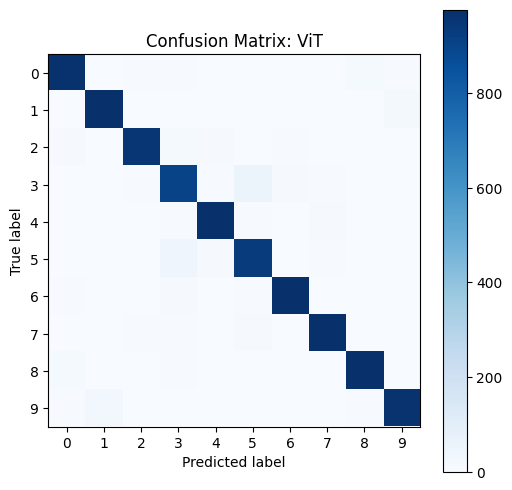

Swin – Test Accuracy      : 91.65%
Swin – Top-1 Error Rate    : 8.35%



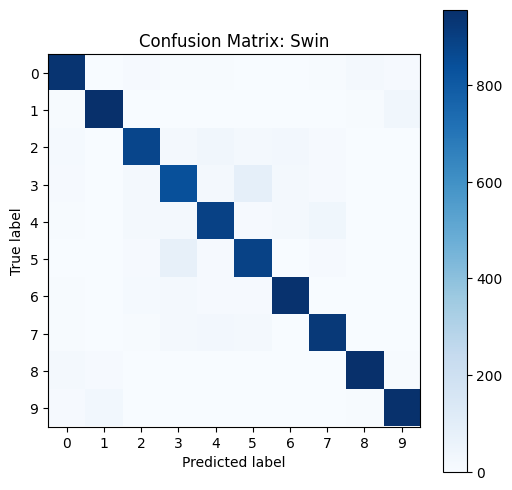

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

for name, model in models.items():
    model.to(device).eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())

    all_preds  = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    acc       = (all_preds == all_labels).mean()
    err_rate  = 1 - acc

    print(f"{name} – Test Accuracy      : {acc*100:.2f}%")
    print(f"{name} – Top-1 Error Rate    : {err_rate*100:.2f}%\n")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


=================================================

In [ ]:
import torch
import timm

device = torch.device('cuda')

vit  = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=10)

vit_path  = '/content/drive/MyDrive/models_cifar10/vit_cifar10.pth'
swin_path = '/content/drive/MyDrive/models_cifar10/swin_cifar10.pth'

vit.load_state_dict(torch.load(vit_path,  map_location='cuda'))
swin.load_state_dict(torch.load(swin_path, map_location='cuda'))

vit.to(device).eval()
swin.to(device).eval()


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# Retrieve an image from the test set
images, labels = next(iter(test_loader))
img_tensor    = images[0].unsqueeze(0).to(device)  # [1,3,224,224]
true_label    = labels[0].item()

In [ ]:
# Denormalize for display
img_np = images[0].cpu().permute(1,2,0).numpy()
mean = np.array([0.4914,0.4822,0.4465])
std  = np.array([0.2470,0.2435,0.2616])
img_np = np.clip(img_np * std + mean, 0, 1)

Plot our image

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

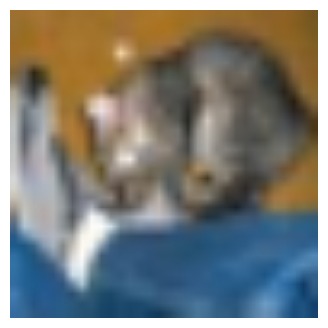

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.axis('off')

100%|██████████| 48/48 [00:08<00:00,  5.47it/s]


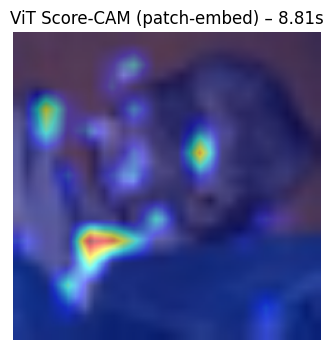

100%|██████████| 6/6 [00:00<00:00, 12.69it/s]


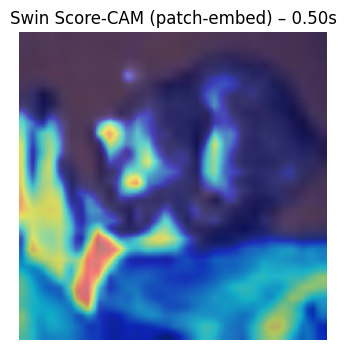

In [ ]:
# ViT Score-CAM
vit_target    = vit.patch_embed.proj
scorecam_vit  = ScoreCAM(model=vit, target_layers=[vit_target])

start = time.time()
grayscale_vit = scorecam_vit(input_tensor=img_tensor)[0]
dt_vit = time.time() - start

cam_vit = show_cam_on_image(img_np, grayscale_vit, use_rgb=True)
plt.figure(figsize=(4,4))
plt.title(f"ViT Score-CAM (patch-embed) – {dt_vit:.2f}s")
plt.imshow(cam_vit)
plt.axis('off')
plt.show()

#  Swin Score-CAM
swin_target     = swin.patch_embed.proj
scorecam_swin   = ScoreCAM(model=swin, target_layers=[swin_target])

start = time.time()
grayscale_swin = scorecam_swin(input_tensor=img_tensor)[0]
dt_swin = time.time() - start

cam_swin = show_cam_on_image(img_np, grayscale_swin, use_rgb=True)
plt.figure(figsize=(4,4))
plt.title(f"Swin Score-CAM (patch-embed) – {dt_swin:.2f}s")
plt.imshow(cam_swin)
plt.axis('off')
plt.show()
